## Walnut Creek TDM - OD Summary by Trip Purpose

This script takes in Streetlight O-D data, summarize the number of OD trips by Day Type, Time of Day, and Trip Purpose.
It outputs heatmaps of OD zones for trips to and from Walnut Creek.

Python 2.7 with Pandas 0.23.4

Input data: 'OD_TP.csv'


1) Day Type: '0: Average Day (M-Su)', '1: Average Weekday (Tu-Th)', '2: Average Weekend Day (Sa-Sa)'

2) Day Part: '00: All Day (12am-12am)', AM Peak - '08: 7am (7am-8am)', '09: 8am (8am-9am)', PM-Peak - '17: 4pm (4pm-5pm)', '18: 5pm (5pm-6pm)'

In [148]:
import os
print os.getcwd(); # Prints the working directory
# set working directory
# os.chdir(default_path)

%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set()

# set comma separator
comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))

C:\Users\mli\Documents\Scripts\Walnut Creek TDM


In [149]:
# read in O-D Trip Purpose data
odtp_df = pd.read_csv('OD_TP.csv')

In [150]:
#od_df.head() # read first 5 rows of data

In [151]:
#odtp_df['Type of Travel'].unique()

In [152]:
list(odtp_df) # get a list of attribute names

['Type of Travel',
 'Origin Zone ID',
 'Origin Zone Name',
 'Origin Zone Is Pass-Through',
 'Origin Zone Direction (degrees)',
 'Origin Zone is Bi-Direction',
 'Destination Zone ID',
 'Destination Zone Name',
 'Destination Zone Is Pass-Through',
 'Destination Zone Direction (degrees)',
 'Destination Zone is Bi-Direction',
 'Day Type',
 'Day Part',
 'O-D Traffic (StL Index)',
 'Purpose HBW (percent)',
 'Purpose HBO (percent)',
 'Purpose NHB (percent)']

In [153]:
# calculate number of HBW, HBO, NHB trips
odtp_df['HBW Trips'] = odtp_df.apply(lambda x: round(x['O-D Traffic (StL Index)'] * x['Purpose HBW (percent)']), axis=1)
odtp_df['HBO Trips'] = odtp_df.apply(lambda x: round(x['O-D Traffic (StL Index)'] * x['Purpose HBO (percent)']), axis=1)
odtp_df['NHB Trips'] = odtp_df.apply(lambda x: round(x['O-D Traffic (StL Index)'] * x['Purpose NHB (percent)']), axis=1)

# select columns we need
df = odtp_df[['Origin Zone ID','Origin Zone Name','Destination Zone ID', 'Destination Zone Name', 'Origin Zone Is Pass-Through','Destination Zone Is Pass-Through', 'Day Type', 'Day Part','O-D Traffic (StL Index)', 'Purpose HBW (percent)', 'Purpose HBO (percent)', 'Purpose NHB (percent)', 'HBW Trips', 'HBO Trips', 'NHB Trips']]

In [154]:
#df['Day Type'].unique()

In [155]:
#df['Day Part'].unique()

In [156]:
# read in lookup table
zone = pd.read_csv('zone_crosswalk.csv')

# rename columns
origin_zone = zone.rename(index=str, columns={"ZoneID": "Origin Zone ID","Street Light Zone":"Origin Street Light Zone", "ST Label": "Origin", "Location": "Origin Location", "Group": "Origin Group", "Employment": "Origin Employment"})
destination_zone = zone.rename(index=str, columns={"ZoneID": "Destination Zone ID","Street Light Zone":"Destination Street Light Zone", "ST Label": "Destination", "Location": "Destination Location", "Group": "Destination Group", "Employment": "Destination Employment"})

In [157]:
#origin_zone

In [158]:
#destination_zone

In [159]:
# join zone lookup table to O-D dataframe
df_o = pd.merge(df, origin_zone, on='Origin Zone ID', validate="many_to_one")
df_od = pd.merge(df_o, destination_zone, on="Destination Zone ID", validate="many_to_one" )

#df_od.head()

In [160]:
# filter out pass-through trips
df_wc= df_od[((df_od['Origin Group'] == 'Walnut Creek') | (df_od['Destination Group'] == 'Walnut Creek')) & (df_od['Origin Zone Is Pass-Through'] == 'no') & (df_od['Destination Zone Is Pass-Through'] == 'no')]
od_wc=df_wc.drop(columns=['Origin Zone Is Pass-Through', 'Destination Zone Is Pass-Through'])
#od_wc.head()

In [161]:
# filter by day part
od_wc_all = od_wc[(od_wc['Day Part'] =='00: All Day (12am-12am)')]
od_wc_am = od_wc[((od_wc['Day Part'] =='08: 7am (7am-8am)')|(od_wc['Day Part'] =='09: 8am (8am-9am)'))]
od_wc_pm = od_wc[((od_wc['Day Part'] =='17: 4pm (4pm-5pm)')|(od_wc['Day Part'] =='18: 5pm (5pm-6pm)'))]

In [162]:
# set group arrays
Day_Type = ['0: Average Day (M-Su)', '1: Average Weekday (Tu-Th)', '2: Average Weekend Day (Sa-Sa)']
Trip_Purpose = ['HBW Trips', 'HBO Trips', 'NHB Trips']
# OD = [' Zone Name', ' Location', ' Group']

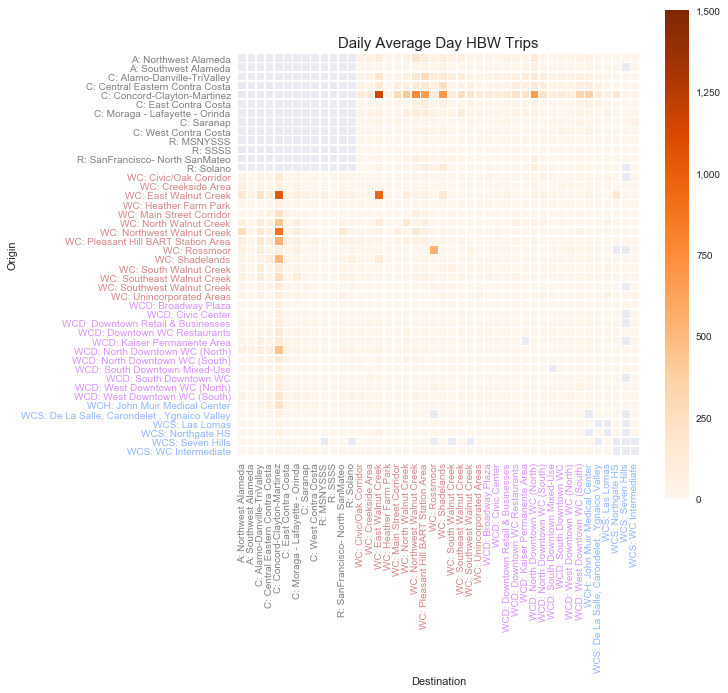

In [179]:
# test the plot
od_wc_all_dt = od_wc_all[(od_wc_all['Day Type'] == '0: Average Day (M-Su)')]
matrix = od_wc_all_dt.pivot_table(values= 'HBW Trips', columns= 'Destination', index='Origin', aggfunc=np.sum)
plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
# plt.xlabel('Origin', size = 12)
# plt.ylabel('Destination', size = 12)
plt.title('Daily' + ' Average Day' + ' HBW Trips', size = 15)
plot = sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Oranges', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=1500,
            cbar_kws={'format':comma_fmt})

# set text label colors
for i in range(13):
    plot.get_xticklabels()[i].set_color('grey')
    plot.get_yticklabels()[i].set_color('grey')
    
for i in range(13, 27):
    plot.get_xticklabels()[i].set_color('#d48686')
    plot.get_yticklabels()[i].set_color('#d48686')
    
for i in range(27, 38):
    plot.get_xticklabels()[i].set_color('#d990ff')
    plot.get_yticklabels()[i].set_color('#d990ff')
    
for i in range(38, 44):
    plot.get_xticklabels()[i].set_color('#90b6ff')
    plot.get_yticklabels()[i].set_color('#90b6ff')

In [164]:
# loop through group and plot
# daily plot
for x in Day_Type:
    od_wc_all_dt = od_wc_all[(od_wc_all['Day Type'] == x)]
    for y in Trip_Purpose:
#         for z in OD:
            # pivot Table
            matrix = od_wc_all_dt.pivot_table(values= y, columns= 'Destination', index='Origin', aggfunc=np.sum)
            # seaborn heatmap documentation
            # https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html
            # https://seaborn.pydata.org/generated/seaborn.heatmap.html
            # color ramps https://matplotlib.org/examples/color/colormaps_reference.html
            # cmap choices: http://matplotlib.org/users/colormaps.html
            plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
#             plt.xlabel('Origin', size = 12)
#             plt.ylabel('Destination', size = 12)
            plt.title('Daily' + ' ' + x[3:] + ' ' + y, size = 15)
            plot=sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Oranges', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=1500,
                        cbar_kws={'format':comma_fmt})
            # set text label colors
            for i in range(14):
                plot.get_xticklabels()[i].set_color('grey')
                plot.get_yticklabels()[i].set_color('grey')
    
            for i in range(14, 27):
                plot.get_xticklabels()[i].set_color('#d48686')
                plot.get_yticklabels()[i].set_color('#d48686')
    
            for i in range(27, 38):
                plot.get_xticklabels()[i].set_color('#d990ff')
                plot.get_yticklabels()[i].set_color('#d990ff')
    
            for i in range(38, 44):
                plot.get_xticklabels()[i].set_color('#90b6ff')
                plot.get_yticklabels()[i].set_color('#90b6ff')
                
            plt.savefig('Daily'+ x[3:] + y + '.pdf', dpi=300, bbox_inches='tight', papertype=None)
            plt.close()

In [175]:
# AM plot
for x in Day_Type[:2]:
    od_wc_am_dt = od_wc_am[(od_wc_am['Day Type'] == x)]
    for y in Trip_Purpose:
#         for z in OD:
            # pivot Table
            matrix = od_wc_am_dt.pivot_table(values= y, columns= 'Destination', index='Origin', aggfunc=np.sum)
            plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
#             plt.xlabel('Origin', size = 12)
#             plt.ylabel('Destination', size = 12)
            plt.title('AM Peak Hour' + ' ' + x[3:] + ' ' + y, size = 15)
            plot=sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Reds', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=500,
                        cbar_kws={'format':comma_fmt})
            # set text label colors
            for i in range(14):
                plot.get_xticklabels()[i].set_color('grey')
                plot.get_yticklabels()[i].set_color('grey')
    
            for i in range(14, 27):
                plot.get_xticklabels()[i].set_color('#d48686')
                plot.get_yticklabels()[i].set_color('#d48686')
    
            for i in range(27, 38):
                plot.get_xticklabels()[i].set_color('#d990ff')
                plot.get_yticklabels()[i].set_color('#d990ff')
    
            for i in range(38, 44):
                plot.get_xticklabels()[i].set_color('#90b6ff')
                plot.get_yticklabels()[i].set_color('#90b6ff')               
            plt.savefig('AM'+ x[3:] + y + '.pdf', dpi=300, bbox_inches='tight', papertype=None)
            plt.close()

od_wc_am_dt = od_wc_am[(od_wc_am['Day Type'] == '2: Average Weekend Day (Sa-Sa)')]
for y in Trip_Purpose:
        matrix = od_wc_am_dt.pivot_table(values= y, columns= 'Destination', index='Origin', aggfunc=np.sum)
        plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
        plt.title('AM Peak Hour' + ' ' + x[3:] + ' ' + y, size = 15)
        plot=sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Reds', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=500,
                cbar_kws={'format':comma_fmt})
        # set text label colors
        for i in range(14):
            plot.get_xticklabels()[i].set_color('grey')
            plot.get_yticklabels()[i].set_color('grey')
    
        for i in range(14, 27):
            plot.get_xticklabels()[i].set_color('#d48686')
            plot.get_yticklabels()[i].set_color('#d48686')
    
        for i in range(27, 38):
            plot.get_xticklabels()[i].set_color('#d990ff')
            plot.get_yticklabels()[i].set_color('#d990ff')
    
        for i in range(38, 44):
            plot.get_xticklabels()[i].set_color('#90b6ff')
        for i in range(38, 43):
            plot.get_yticklabels()[i].set_color('#90b6ff')               
        plt.savefig('AM'+ 'Average Weekend Day (Sa-Sa)' + y + '.pdf', dpi=300, bbox_inches='tight', papertype=None)
        plt.close()


In [177]:
# PM plot
for x in Day_Type[:2]:
    od_wc_pm_dt = od_wc_pm[(od_wc_pm['Day Type'] == x)]
    for y in Trip_Purpose:
#         for z in OD:
            # pivot Table
            matrix = od_wc_pm_dt.pivot_table(values= y, columns= 'Destination', index='Origin', aggfunc=np.sum)
            plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
#             plt.xlabel('Origin', size = 12)
#             plt.ylabel('Destination', size = 12)
            plt.title('PM Peak Hour' + ' ' + x[3:] + ' ' + y, size = 15)
            plot=sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=500,
                        cbar_kws={'format':comma_fmt})
            # set text label colors
            for i in range(14):
                plot.get_xticklabels()[i].set_color('grey')
                plot.get_yticklabels()[i].set_color('grey')
    
            for i in range(14, 27):
                plot.get_xticklabels()[i].set_color('#d48686')
                plot.get_yticklabels()[i].set_color('#d48686')
    
            for i in range(27, 38):
                plot.get_xticklabels()[i].set_color('#d990ff')
                plot.get_yticklabels()[i].set_color('#d990ff')
    
            for i in range(38, 44):
                plot.get_xticklabels()[i].set_color('#90b6ff')
                plot.get_yticklabels()[i].set_color('#90b6ff')               
            plt.savefig('PM'+ x[3:] + y + '.pdf', dpi=300, bbox_inches='tight', papertype=None)
            plt.close()

od_wc_pm_dt = od_wc_pm[(od_wc_pm['Day Type'] == '2: Average Weekend Day (Sa-Sa)')]
for y in Trip_Purpose:
        matrix = od_wc_pm_dt.pivot_table(values= y, columns= 'Destination', index='Origin', aggfunc=np.sum)
        plt.figure(figsize=(9,9), facecolor='#FFFFFF',edgecolor='#FFFFFF', clear=True)
        plt.title('PM Peak Hour' + ' ' + x[3:] + ' ' + y, size = 15)
        plot=sns.heatmap(matrix, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues', annot = None, xticklabels=True, yticklabels=True, vmin=0, vmax=500,
                cbar_kws={'format':comma_fmt})
        # set text label colors
        for i in range(14):
            plot.get_xticklabels()[i].set_color('grey')
            plot.get_yticklabels()[i].set_color('grey')
    
        for i in range(14, 27):
            plot.get_xticklabels()[i].set_color('#d48686')
            plot.get_yticklabels()[i].set_color('#d48686')
    
        for i in range(27, 38):
            plot.get_xticklabels()[i].set_color('#d990ff')
            plot.get_yticklabels()[i].set_color('#d990ff')
    
        for i in range(38, 43):
            plot.get_xticklabels()[i].set_color('#90b6ff')
        for i in range(38, 44):
            plot.get_yticklabels()[i].set_color('#90b6ff')               
        plt.savefig('PM'+ 'Average Weekend Day (Sa-Sa)' + y + '.pdf', dpi=300, bbox_inches='tight', papertype=None)
        plt.close()